In [60]:
# import all necessary libraries here
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler      # Normalization methods
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import scipy.stats as stats


# 1. Impute Missing Values
def impute_missing_values(data, strategy='mean'):
    """
    Fill missing values in the dataset.
    :param data: pandas DataFrame
    :param strategy: str, imputation method ('mean', 'median', 'mode')
    :return: pandas DataFrame
    """



    # missing_data = data.isnull().mean()
    # to_drop = missing_data[missing_data > 0.5].index.to_list()
    # data.drop(columns = to_drop, inplace = True)

    # For numeric, do either mean, median, or mode
    # But for categorical, do mode

    for col in data.select_dtypes(include=np.number).columns[1:]:       # .columns only extracts the column name, so we need to 
        if strategy == 'mean':                                          # subsequently call data[col] to modify that entire column.
            data[col].fillna(data[col].mean(), inplace=True)
        elif strategy == 'median':
            data[col].fillna(data[col].median(), inplace=True)
        elif strategy == 'mode':
            data[col].fillna(data[col].mode()[0], inplace=True)

    # for col in data.select_dtypes(include='object').columns:
    #     data[col].fillna(data[col].mode()[0], inplace=True)
    


    return data

# 2. Remove Duplicates
def remove_duplicates(data):
    """
    Remove duplicate rows from the dataset.
    :param data: pandas DataFrame
    :return: pandas DataFrame
    """
    data.drop_duplicates(inplace = True)    
    return data

# 2.5. Replacing outlier with mean
def replace_outlier(data):

    # Copy original data
    data_cleaned = data.copy()

    # Select numeric columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(data_cleaned[numeric_cols], nan_policy='omit'))
    # Replace outliers (Z-score > 3) with NaN
    data[numeric_cols] = data[numeric_cols].mask(z_scores >= 3)

    # Fill NaNs (outliers) with column means
    for col in numeric_cols:
        mean_val = data[col].mean()
        data[col].fillna(mean_val, inplace=True)
    return data


# 3. Normalize Numerical Data
def normalize_data(data,method='minmax'):
    """Apply normalization to numerical features.
    :param data: pandas DataFrame
    :param method: str, normalization method ('minmax' (default) or 'standard')
    """
    
    # Set normalization method
    if method == "standard":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()

    # Apply normalization to numerical columns only
    numeric_col =  data.select_dtypes(include=np.number).columns
    data[numeric_col] = scaler.fit_transform(data[numeric_col])

    # Convert first column back to categorical (0 or 1)
    data['target'] = (data['target'] > 0.5).astype(int)             

    return data

# 4. Remove Redundant Features   
def remove_redundant_features(data, threshold=0.9):
    """Remove redundant or duplicate columns.
    :param data: pandas DataFrame
    :param threshold: float, correlation threshold
    :return: pandas DataFrame
    """
    # On numerical columns, calculate the correlation (Pearson method) using .corr()
    # .abs() get absolute value. 
    corr_matrix = data.select_dtypes(include=np.number).corr().abs()

    # np.ones() Create a new matrix with the same dimension as the original correlation matrix and fill the values with 1s.
    # np.triu() Get upper triangle of the matrix, indicated by 1s and 0s.
    # .astype(bool) Convert 0 -> F and 1 -> T.
    # corr_matrix.where() To apply selection to original correlation matrix.
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify any columns within the upper correlation matrix that has a high correlation value with another column/
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

    # Drop those chosen columns
    data = data.drop(columns=to_drop)


    return data




# ---------------------------------------------------

def simple_model(input_data, split_data=True, scale_data=False, print_report=False):
    """
    A simple logistic regression model for target classification.
    Parameters:
    input_data (pd.DataFrame): The input data containing features and the target variable 'target' (assume 'target' is the first column).
    split_data (bool): Whether to split the data into training and testing sets. Default is True.
    scale_data (bool): Whether to scale the features using StandardScaler. Default is False.
    print_report (bool): Whether to print the classification report. Default is False.
    Returns:
    None
    The function performs the following steps:
    1. Removes columns with missing data.
    2. Splits the input data into features and target.
    3. Encodes categorical features using one-hot encoding.
    4. Splits the data into training and testing sets (if split_data is True).
    5. Scales the features using StandardScaler (if scale_data is True).
    6. Instantiates and fits a logistic regression model.
    7. Makes predictions on the test set.
    8. Evaluates the model using accuracy score and classification report.
    9. Prints the accuracy and classification report (if print_report is True).
    """

    # if there's any missing data, remove the columns
    input_data.dropna(inplace=True)

    # split the data into features and target
    target = input_data.copy()[input_data.columns[0]]
    features = input_data.copy()[input_data.columns[1:]]

    # if the column is not numeric, encode it (one-hot)
    for col in features.columns:
        if features[col].dtype == 'object':
            features = pd.concat([features, pd.get_dummies(features[col], prefix=col)], axis=1)
            features.drop(col, axis=1, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

    if scale_data:
        # scale the data
        X_train = normalize_data(X_train)
        X_test = normalize_data(X_test)
        
    # instantiate and fit the model
    log_reg = LogisticRegression(random_state=42, max_iter=100, solver='liblinear', penalty='l2', C=1.0)
    log_reg.fit(X_train, y_train)

    # make predictions and evaluate the model
    y_pred = log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    
    # if specified, print the classification report
    if print_report:
        print('Classification Report:')
        print(report)
        print('Read more about the classification report: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html and https://www.nb-data.com/p/breaking-down-the-classification')
    
    return None


In [61]:
# Import necessary modules
# import data_preprocessor as dp
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Load the dataset
messy_data = pd.read_csv('../Data/messy_data.csv')
clean_data = messy_data.copy()

# 2. Preprocess the data
clean_data = impute_missing_values(clean_data, strategy='mean')
clean_data = remove_duplicates(clean_data)

clean_data = replace_outlier(clean_data)
clean_data = normalize_data(clean_data)
clean_data = remove_redundant_features(clean_data)

# 3. Save the cleaned dataset
clean_data.to_csv('../Data/clean_data.csv', index=False)

# 4. Train and evaluate the model
simple_model(clean_data)

Accuracy: 0.8229166666666666


/var/folders/4g/rcj0yxyd1rg5h5l6_l1217k00000gn/T/ipykernel_30998/752385443.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
/var/folders/4g/rcj0yxyd1rg5h5l6_l1217k00000gn/T/ipykernel_30998/752385443.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

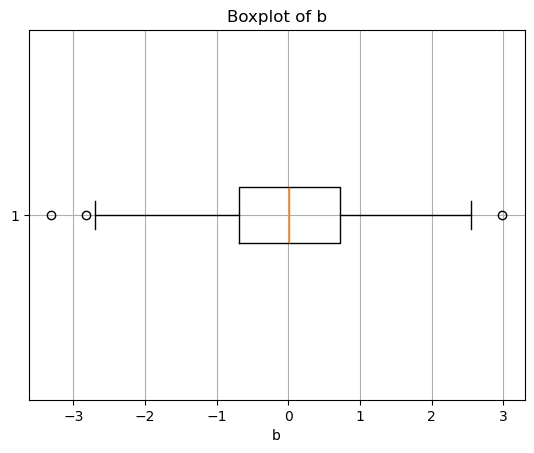

In [6]:
import matplotlib.pyplot as plt
messy_data = pd.read_csv('../Data/messy_data.csv')
column = 'b'

plt.figure()
plt.boxplot(messy_data[column].dropna(), vert=False)
plt.title(f'Boxplot of {column}')
plt.xlabel(column)
plt.grid(True)
plt.show()
